## Variational autoencoder 1D
This example shows how to build variational autoencoder (VAE) model in tf.Keras for 1D data

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K

import matplotlib

Enable memory growth for GPU, it is needed on some systems for convolution to work.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

Read data, containing four categories of spectra

In [3]:
data = pd.read_csv("./spectra.csv.gz").values
datax = data[:,:-1]
labels = data[:,-1]

In [4]:
labels = tf.keras.utils.to_categorical(labels)

Define dimensionality of the input data, of latent space and leaking coefficient for LeakyReLU units. Please note that 2D latent space is inadequate for complex data description such as spectra, so prediction will probably be far from perfection, but it will allow us to visualize the space later.

In [5]:
inp_dim = datax.shape[1]
n_classes = labels.shape[1]
hidden_dim = 2
a = 0.1

Reparametrization trick - instead of sampling from $q(Z|X)=\mathcal{N}(\mu(X,\theta),\Sigma(X,\theta))$, which is indifferentiable, we sample from $\mathcal{N}(0,1)$ and use properties of normal distribution, namely 
$$ X \sim \mathcal{N}(0,1) \\
\Sigma^{1/2}X+\mathbf{\mu} \sim \mathcal{N}(\mathbf{\mu}, \Sigma)$$
to shift mean and scale variance. We've assumed diagonality of $\Sigma$, so multiplication by $\Sigma^{1/2}$ can be replaced with pointwise multiplication by the vector of diagonal standard deviations $\sqrt{\mathbf{\sigma^2}}$, predicted by the encoder.

Since later calculation involve taking log of the variance, it is useful to assume that NN model already predicts log of variance, which will save us from getting NaNs if model output negative number. Thus, here we need to exponentiate log of variance to get $\mathbf{\sigma}^2$, or even better divide by two before exponentiation to directly get $\mathbf{\sigma}$

In [6]:
def reparametrization(mu, log_sigma):
    batch_size = tf.shape(mu)[0]
    epsilon = tf.random.normal(shape=(batch_size, hidden_dim), mean=0.0, stddev=1.0)
    return tf.math.exp(log_sigma/2)*epsilon+mu

Now define convolutional encoder model. To allow the acceptance of direct data matrix (i.e. without addition of the channel dimension) we perform this addition directly in the model. Predicted $\mathbf{\mu}$ and $\mathbf{\sigma}$ are used to sample from $q(Z|X)$.

In [7]:
data_input = Input(shape=(inp_dim,))

labels_input = Input(shape=(n_classes,))

x = Reshape((inp_dim,1))(data_input)

x = Conv1D(2, 10, padding="same")(x)
x = LeakyReLU(a)(x)
x = MaxPool1D(2)(x)

x = Conv1D(2, 20, padding="same")(x)
x = LeakyReLU(a)(x)

x = Flatten()(x)

x = Concatenate()([x, labels_input])

x = Dense(100, activation="linear")(x)
x = LeakyReLU(a)(x)

x = Dense(50, activation="linear")(x)
x = LeakyReLU(a)(x)

mu = Dense(hidden_dim, activation="linear")(x)
log_sigma_diag = Dense(hidden_dim, activation="linear")(x)

enc_out = reparametrization(mu, log_sigma_diag)
encoder = Model([data_input, labels_input], enc_out)

Similarly, define decoder, that approximates $p(X|Z)$. We again using reshape to add channel dimension here.

In [13]:
hidden_input = Input(shape=(hidden_dim,))

x = Concatenate()([hidden_input, labels_input])
x = Dense(50, activation="linear")(x)
x = LeakyReLU(a)(x)

x = Dense(100, activation="linear")(x)
x = LeakyReLU(a)(x)

x = Dense(inp_dim//2, activation="linear")(x)
x = LeakyReLU(a)(x)

x = Reshape((inp_dim//2, 1))(x)

x = Conv1D(2, 20, padding="same")(x)
x = LeakyReLU(a)(x)
x = UpSampling1D(2)(x)

x = Conv1D(1, 20, padding="same")(x)
x = LeakyReLU(a)(x)

dec_out = Flatten()(x)

decoder = Model([hidden_input,labels_input], dec_out)

Now, the optimization criterion is given by:
    $$\mathbb{E}_{X\sim D}\Big[\mathbb{E}_{\mathcal{E}\sim\mathcal{N}(\mathbf{0},I)}\big[\text{log}\,p\big(X|z=\mu(X,\theta_{1})+\sigma^{2}(X,\theta_{1})\mathcal{E}\big)\big]-D_{KL}[q(Z|X,\theta_{2})||p(Z)]\Big]$$
Its first part maximizes probability to observe the data $X$ at the decoder output. We will replace it with reconstruction loss, a simple sum of squared errors.

In [14]:
def sse_loss(X_true, X_reconst):
    loss = K.sum((X_true - X_reconst)**2, axis=-1)
    return  loss

The second part of the optimization criterion minimizes Kullback-Leibler divergence between encoder output and its desired shape ($\mathcal{N}(\mathbf{0},I)$ in that case). The divergence is given by $$\frac{1}{2}[\text{tr}\,\Sigma(X)+\mu(X)^{T}\mu(X)-k-\text{log}\,\det\Sigma(X)]$$

since our model already outputs logarithm of the $\Sigma$ diagonal, we need to exponentiate and sum it to get $\text{tr}\,\Sigma(X)$, vector $\mu$ can be squared elementwise and added. Determinant of diagonal matrix is equal to the the product of diagonal elements, and since we already have logarithms of them it simplifies to the summation of the vector of logarithms. Since all three summation are performed over same exis (hidden space dimensionality) we wil replace them by a single sum and subtract $k$. As a final step we use K.mean to get average divergence over batch.

In [15]:
kl_loss =  K.mean(0.5*(K.sum(K.exp(log_sigma_diag) + mu**2 - log_sigma_diag, axis=-1) - hidden_dim))

Now, with everything setup we can define the VAE model as mapping from encoder input to the decoder output and add the KL loss to it (since it is independent on the model inputs and outputs it can't be passed at model compile step).

In [18]:
vae = Model([data_input, labels_input], decoder([enc_out, labels_input]))
vae.add_loss(kl_loss)

Here we will add reconstruction loss and compile the model with adam optimizer.

In [19]:
vae.compile(loss=sse_loss, optimizer="adam")

And finally train it on the spectra data.

In [21]:
vae.fit([datax, labels], datax, batch_size=32, epochs=100)

Train on 1388 samples
Epoch 1/100
1388/1388 [==============================] - 4s 3ms/sample - loss: 63.6833
Epoch 2/100
1388/1388 [==============================] - 1s 454us/sample - loss: 14.0041
Epoch 3/100
1388/1388 [==============================] - 1s 468us/sample - loss: 7.8442
Epoch 4/100
1388/1388 [==============================] - 1s 465us/sample - loss: 6.5537
Epoch 5/100
1388/1388 [==============================] - 1s 463us/sample - loss: 6.0040
Epoch 6/100
1388/1388 [==============================] - 1s 470us/sample - loss: 5.6248
Epoch 7/100
1388/1388 [==============================] - 1s 472us/sample - loss: 5.3544
Epoch 8/100
1388/1388 [==============================] - 1s 468us/sample - loss: 4.8846
Epoch 9/100
1388/1388 [==============================] - 1s 469us/sample - loss: 4.3746
Epoch 10/100
1388/1388 [==============================] - 1s 457us/sample - loss: 4.0597
Epoch 11/100
1388/1388 [==============================] - 1s 457us/sample - loss: 3.9142
Epoch 12

Epoch 93/100
1388/1388 [==============================] - 1s 454us/sample - loss: 2.9581
Epoch 94/100
1388/1388 [==============================] - 1s 467us/sample - loss: 2.9512
Epoch 95/100
1388/1388 [==============================] - 1s 463us/sample - loss: 2.9836
Epoch 96/100
1388/1388 [==============================] - 1s 458us/sample - loss: 3.0042
Epoch 97/100
1388/1388 [==============================] - 1s 454us/sample - loss: 2.9676
Epoch 98/100
1388/1388 [==============================] - 1s 462us/sample - loss: 2.9433
Epoch 99/100
1388/1388 [==============================] - 1s 470us/sample - loss: 2.9780
Epoch 100/100
1388/1388 [==============================] - 1s 465us/sample - loss: 2.9919


Tune the visual parameters

In [22]:
matplotlib.style.use("ggplot")
matplotlib.rcParams['figure.figsize'] = (8,6)

Have a look at the hidden space distibution, which is not perfectly normal, of course, but relatively close to normality.

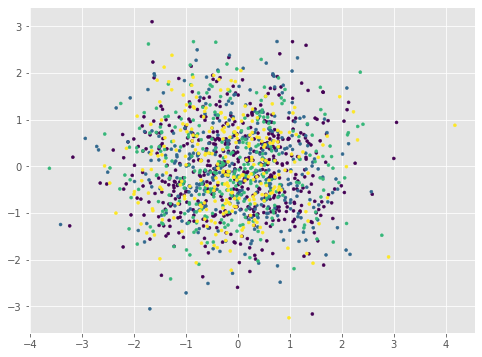

In [27]:
emb = encoder.predict([datax,labels])
plt.scatter(emb[:,0], emb[:,1], c=np.argmax(labels, axis=1), marker=".")

Lets plot few spectra to estimate reconstruction quality. The quality is worse since 2D hidden space is insufficient to capture all data variability.

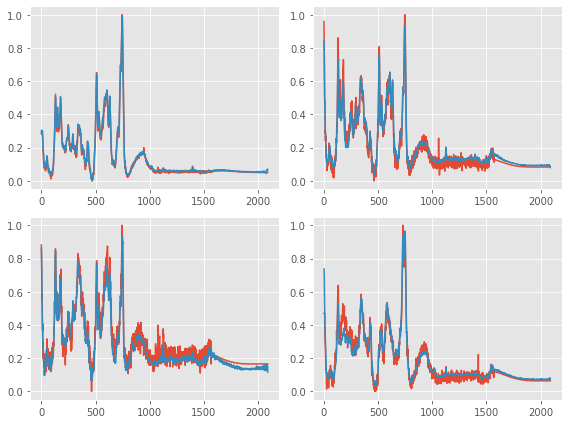

In [30]:
idx=1
for i in [1, 20, 235, 1023]:
    plt.subplot(2,2,idx)
    plt.plot(datax[i])
    plt.plot(np.squeeze(vae.predict([datax[i:i+1], labels[i:i+1]])))
    idx+=1
plt.tight_layout()

Now, the most interesting part. Since our hidden space is approximately normal we can explore it by sampling various points on the grid and decoding them by the decoder. In that way, we can generate new spectra and get some understanding of hidden space structure. 
Unfortunately, it is not very easy to see relatively tiny differences in the spectra for unprofessional eye, so the next example will apply VAE to images.

In [32]:
labels[0]

array([1., 0., 0., 0.], dtype=float32)

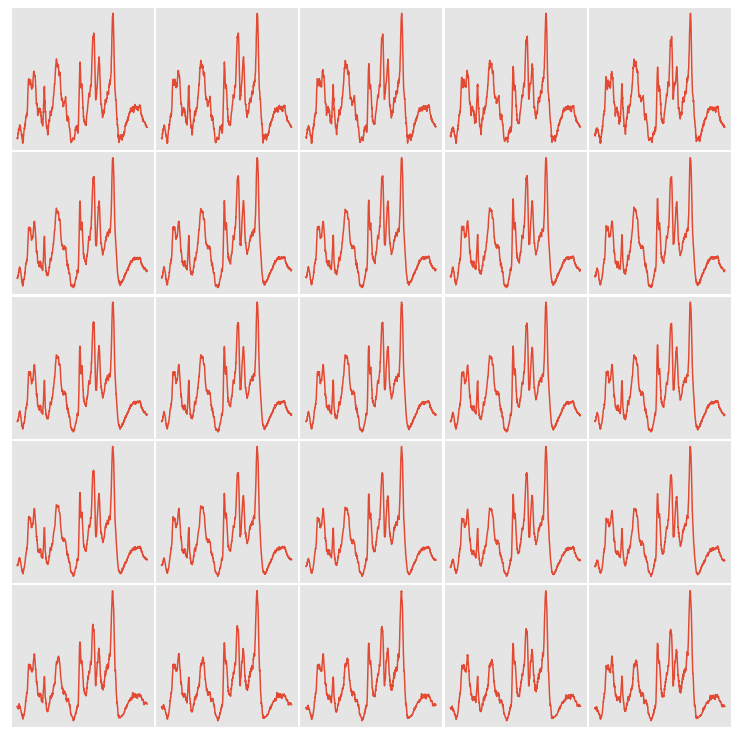

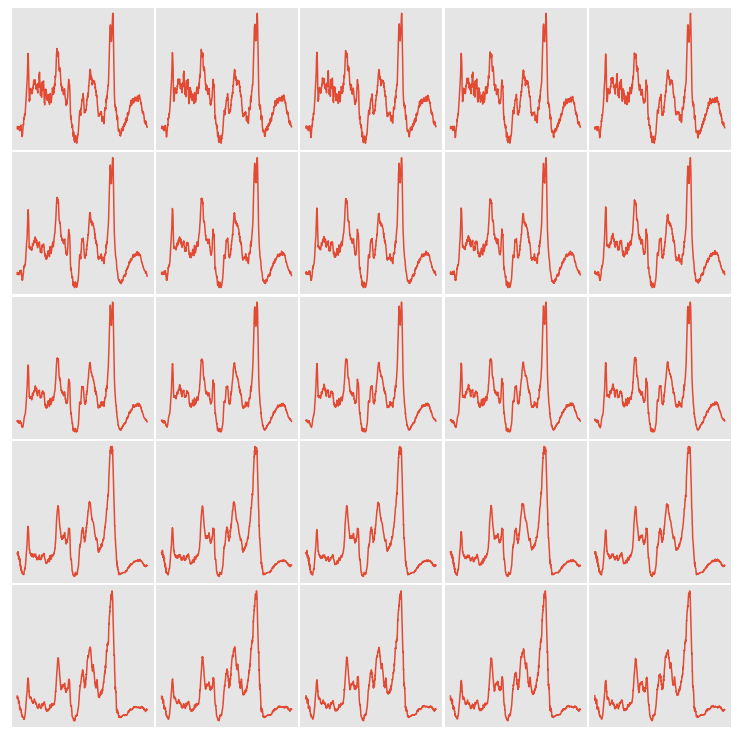

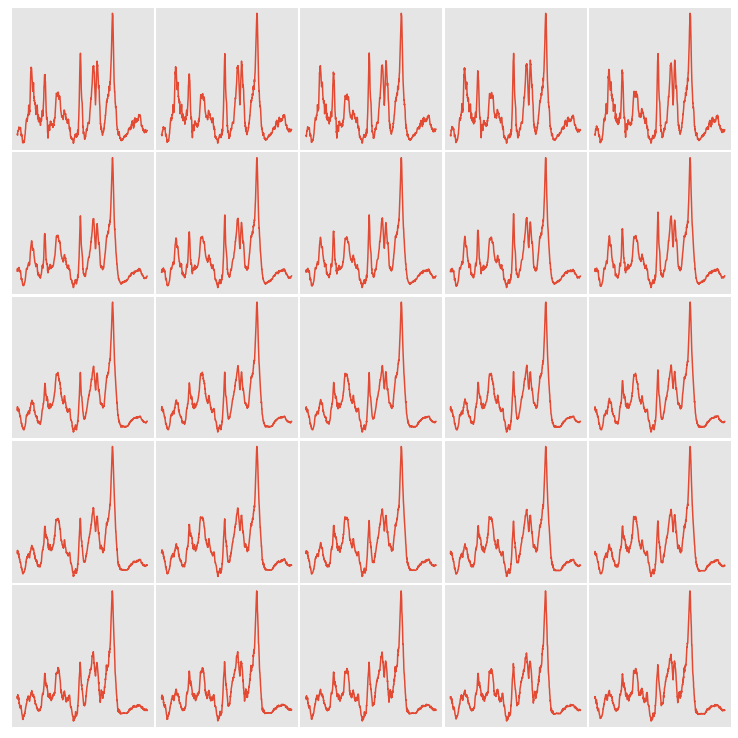

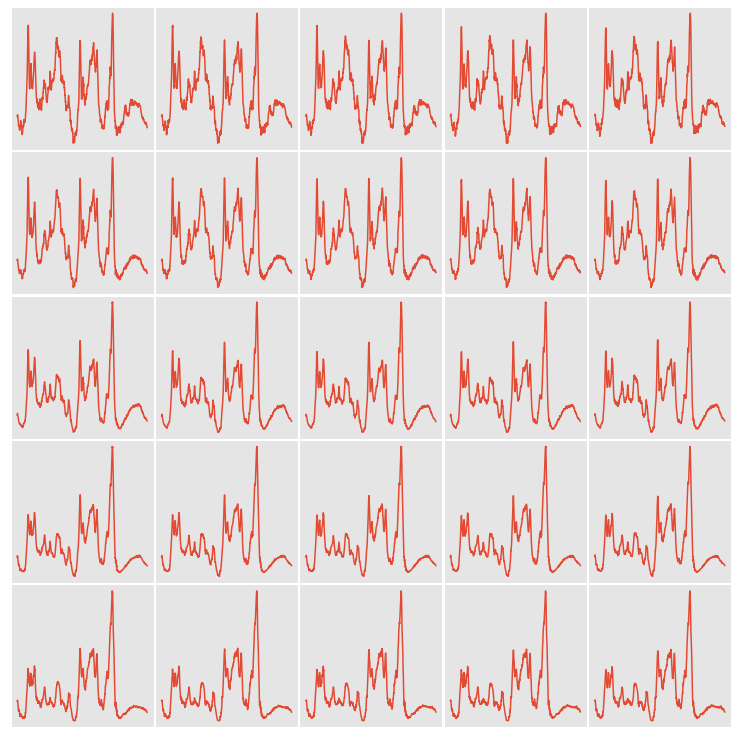

<Figure size 720x720 with 0 Axes>

In [65]:
matplotlib.rcParams['figure.figsize'] = (10, 10)

grsize = (5, 5)
c = 1.0

xgrid = np.linspace(emb[:, 0].min() * c, emb[:, 0].max() * c, grsize[0])
ygrid = np.linspace(emb[:, 1].min() * c, emb[:, 1].max() * c, grsize[1])

for label in np.unique(labels, axis=0):
    idx = 1
    for x in xgrid:
        for y in ygrid:
            decoded = decoder([np.array([[x, y]]), label[np.newaxis,:]]).numpy()
            ax = plt.subplot(grsize[0], grsize[1], idx)
            plt.plot(np.squeeze(decoded)[50:1000])
            #plt.axis("off")
            plt.xticks([], [])
            plt.yticks([], [])
            #ax.set_facecolor("lightslategray")
            idx += 1
    plt.tight_layout(-0.2)
    plt.figure()
